In [0]:
import os
img_dir='/tmp/style_transfer'
if not os.path.exists(img_dir):
  os.makedirs(img_dir)
!wget --quiet -P /tmp/style_transfer/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/style_transfer/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/style_transfer/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/style_transfer/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/style_transfer/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/style_transfer/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize']=(10,10)
mpl.rcParams['axes.grid']=False

import numpy as np
from PIL import Image
import time
import functools
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [0]:
tf.enable_eager_execution()
print(tf.executing_eagerly())

True


In [0]:
content_img= '/tmp/style_transfer/Green_Sea_Turtle_grazing_seagrass.jpg'
style_img = '/tmp/style_transfer/The_Great_Wave_off_Kanagawa.jpg'

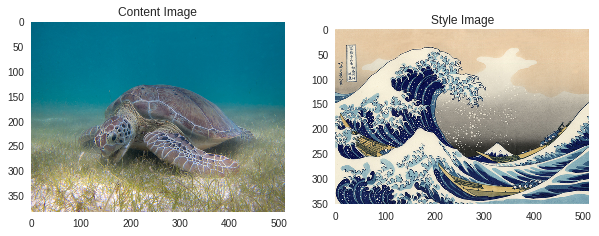

In [0]:
def load_img(image_path):
  max_dim = 512
  img = Image.open(image_path)
  long=max(img.size)
  scale=max_dim/long
  img=img.resize((round(img.size[0]*scale),round(img.size[1]*scale)), Image.ANTIALIAS)
  img=kp_image.img_to_array(img)
  img=np.expand_dims(img,axis=0)  # to broadcast the img_array to ensure that it has a batch dimension.
  
  return img


def show_img(img, title=None):
  
  out_img=np.squeeze(img, axis=0)
  out_img=out_img.astype('uint8')
  plt.imshow(out_img)
  if title is not None:
    plt.title(title)
    

plt.figure(figsize=(10,10))

content = load_img(content_img).astype('uint8')
style = load_img(style_img).astype('uint8')

plt.subplot(1, 2, 1)
show_img(content, 'Content Image')

plt.subplot(1, 2, 2)
show_img(style, 'Style Image')
plt.show()

In [0]:
# for input image
def load_preprocess_img(img_path):
  img=load_img(img_path)
  img=tf.keras.applications.vgg19.preprocess_input(img)
  return img

# for the generated output image
def deprocess(processed_outputimg):
  x=processed_outputimg.copy()
  if (len(x.shape)==4):
    x=np.squeeze(x,0)
  assert len(x.shape)==3
  
  if (len(x.shape)!=3):
    raise ValueError("Invalid dimensions of input to deprocessing image")
    
  x[:, :, 0] += 103.939 # inverse preprocessing; since vgg19 is trained on input image normalized by mean = [103.939, 116.779, 123.68] for the channels BGR.
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8') # clipping to ensure that final values remain within range 0-255.
  return x

In [0]:
# we are using vgg19 pretrained network on image classification in order to access the intermediate layers for style and content transfer.
# this is possible because; the model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images. 

In [0]:
content_layers = ['block5_conv2']    # 14 X 14 X 512


style_layers = ['block1_conv1',      # 224 X 224 X 64
                'block2_conv1',      # 112 X 112 X 128
                'block3_conv1',      # 56 X 56 X 256
                'block4_conv1',      # 28 X 28X 512
                'block5_conv1'       # 14 X 14 X 512
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def define_model():
  
  vgg19=tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg19.trainable=False
  
  style_outputs=[vgg19.get_layer(name).output for name in style_layers]
  content_outputs=[vgg19.get_layer(name).output for name in content_layers]
  model_outputs=style_outputs + content_outputs
  
  return models.Model(vgg19.input,model_outputs)

In [0]:
# Loss functions 
 
def get_content_loss(baseimg_content, target):
  return tf.reduce_mean(tf.square(baseimg_content - target))

In [0]:
def gram_matrix(input_tensor):
  channels=int(input_tensor.shape[-1])
  a=tf.reshape(input_tensor,[-1,channels])
  n=tf.shape(a)[0]
  gram = tf.matmul(a,a , transpose_a= True)
  return gram/tf.cast(n,tf.float32)

def get_style_loss(baseimg_style,target_gram):
  
  height,width, channels=baseimg_style.get_shape().as_list()
  style_gram=gram_matrix(baseimg_style)
  
  return tf.reduce_mean(tf.square(style_gram - target_gram)) # / (4. * (channels ** 2) * ((width * height) ** 2)) 

In [0]:
# using adam optimizer
# Note: all the inputs, intermediate and output layers of vgg19 have a batch dimension(4th dimension). 

def feature_representations(model,content_img, style_img):
  
  content_image=load_preprocess_img(content_img)
  style_image=load_preprocess_img(style_img)
  
  outputs1=model(style_image)
  outputs2=model(content_image)
  
  style_features=[style_layers[0] for style_layers in outputs1[:num_style_layers]]
  content_features=[content_layer[0]  for content_layer in outputs2[num_style_layers:]]
  
  return style_features, content_features

In [0]:
# Here we use tf.GradientTape to compute the gradient. It allows us to take advantage of the automatic differentiation available by tracing operations for computing the gradient later. It records the operations during the forward pass and then is able to compute the gradient of our loss function with respect to our input image for the backwards pass.

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  
  style_weight, content_weight = loss_weights # variational loss?
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_loss = 0
  content_loss = 0

  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  
  for target_style_gram, output_style in zip(gram_style_features, style_output_features):
    style_loss += weight_per_style_layer *get_style_loss(output_style[0], target_style_gram)
    
    
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, output_content in zip(content_features, content_output_features):
    content_loss += weight_per_content_layer* get_content_loss(output_content[0], target_content)
    
  
  loss = style_loss*style_weight + content_loss*content_weight 
  return loss, style_loss, content_loss

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Computing gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
import IPython.display

def run_style_transfer(content_img, style_img,num_iterations=1000,content_weight=1e3, style_weight=1e-2): 
  
  # trainable to false. 
  model = define_model() 
  for layer in model.layers:
    layer.trainable = False
  
   
  style_features, content_features = feature_representations(model, content_img, style_img)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  init_image = load_preprocess_img(content_img)
  init_image = tfe.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1 #?
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  loss_weights = (style_weight, content_weight)
  config = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means  
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(config)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      plot_img = init_image.numpy()
      plot_img = deprocess(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss

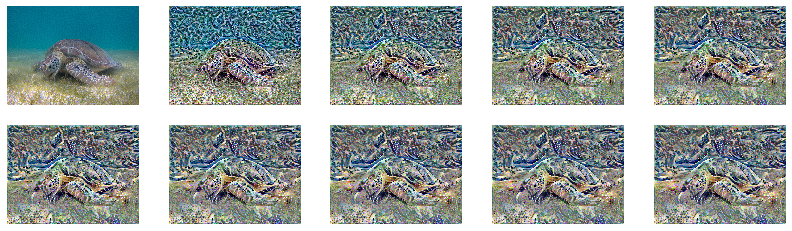

In [0]:
best, best_loss = run_style_transfer(content_img, 
                                     style_img, num_iterations=1000)

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  show_img(content, 'Content Image')

  plt.subplot(1, 2, 2)
  show_img(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()
    
    
show_results(best, content_img, style_img)